## GMM clustering

In [1]:
# gmm_model.py
import pandas as pd
import os
import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define features
features = [
    'danceability', 'energy', 'key', 'loudness', 'speechiness', 
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]

# Load dataset
parent_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
file_path = os.path.join(parent_dir, "data", "spotify_cleaned.csv")
train_data = pd.read_csv(file_path)



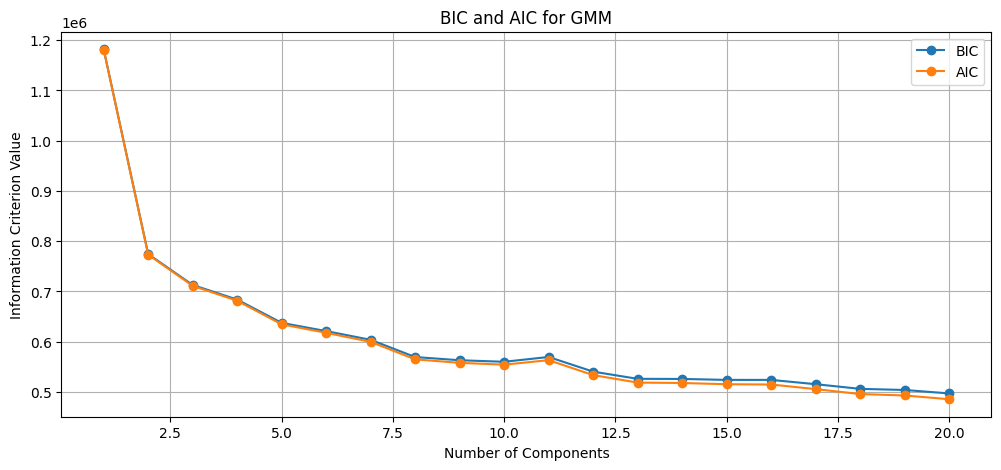

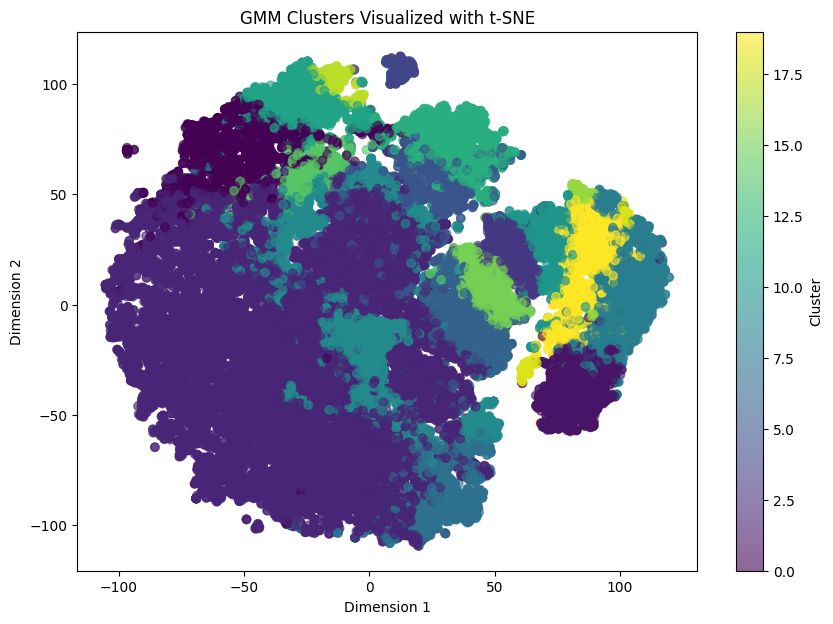

                           artists            album_name  \
113185            Hillsong Worship         No Other Name   
42819                 Internal Rot        Grieving Birth   
59311   Zhoobin Askarieh;Ali Sasha  Noise A Noise 20.4-1   
90416                   Billy Fury      A Thousand Stars   
61000                   Nogizaka46            バレッタ TypeD   

                    track_name  popularity  duration_ms  explicit  \
113185           No Other Name          50       440247     False   
42819           Failed Organum          11        93933     False   
59311    Save the Trees, Pt. 1           0       213578     False   
90416   It's Only Make Believe          34       146706     False   
61000                    月の大きさ          57       236293     False   

        danceability  energy  key  loudness  mode  speechiness  acousticness  \
113185         0.369   0.598    7    -6.984     1       0.0304       0.00511   
42819          0.171   0.997    7    -3.586     1       0.1180  

In [2]:
from sklearn.manifold import TSNE

# Sample 40% of the data
train_data = train_data.sample(frac=0.4, random_state=42)

# Scale the data using RobustScaler
scaler = RobustScaler()
X = scaler.fit_transform(train_data[features])

# Hyperparameter tuning for the number of components
bic = []
aic = []
n_components_range = range(1, 21)  # Adjust as necessary

for n_components in n_components_range:
    gmm_model = GaussianMixture(n_components=n_components, random_state=42)
    gmm_model.fit(X)
    bic.append(gmm_model.bic(X))
    aic.append(gmm_model.aic(X))

# Plot BIC and AIC values
plt.figure(figsize=(12, 5))
plt.plot(n_components_range, bic, marker='o', label='BIC')
plt.plot(n_components_range, aic, marker='o', label='AIC')
plt.title('BIC and AIC for GMM')
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion Value')
plt.legend()
plt.grid()
plt.show()

# Choose the optimal number of components based on BIC/AIC
optimal_n_components = n_components_range[bic.index(min(bic))]
# Apply PCA before fitting the GMM model
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
# Train the final GMM Model with different covariance types
final_gmm_model = GaussianMixture(n_components=optimal_n_components, covariance_type='tied', random_state=42)
train_data['cluster'] = final_gmm_model.fit_predict(X_pca)


# Save the scaler and GMM model separately
model_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'models'))
model_path = os.path.join(model_dir, 'gmm_model.pkl')
scaler_path = os.path.join(model_dir, 'RobustScaler.pkl')

joblib.dump(scaler, scaler_path)
joblib.dump(final_gmm_model, model_path)

# Save the clustered training data
train_data.to_csv("gmm_model_data.csv", index=False)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_data['cluster'], cmap='viridis', alpha=0.6)
plt.title('GMM Clusters Visualized with t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(label='Cluster')
plt.show()


print(train_data.head(5))